In [1]:
import numpy as np
import pandas as pd
#%pylab inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

## Task 1: Data dimensionality, distance-based classifiers
Excercise with mnist digit dataset. Lets first load the data and take a peek:

In [2]:
X_train = pd.read_csv('./data/train_in.csv',header=None)
Y_train = pd.read_csv('./data/train_out.csv',header=None)
df_train = X_train.copy()
df_train['label']=Y_train

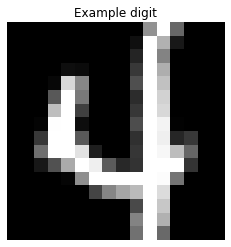

In [3]:
def show_number(nr,data):    
    X=np.array(data)
    X=np.reshape(X[nr,:],(16,16))
    imgplot = plt.imshow(X,cmap='gray')
    plt.axis('off')
    
    plt.title('Example digit')
    plt.show()
show_number(np.random.randint(0,10),X_train)


How big is the difference between numbers?

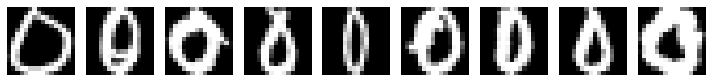

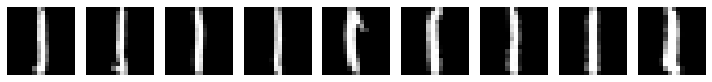

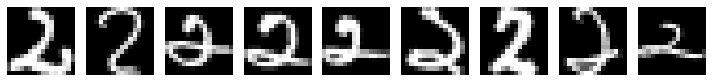

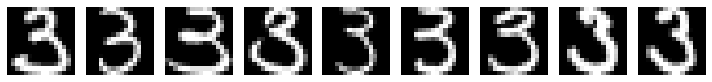

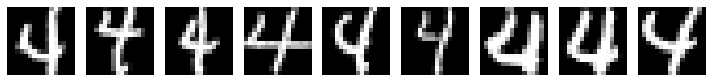

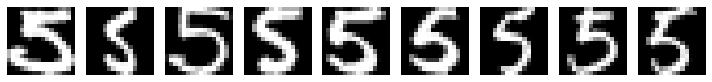

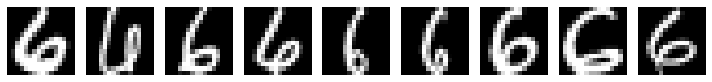

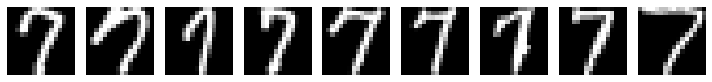

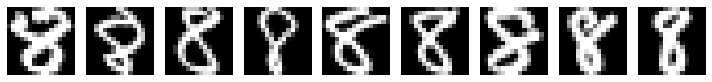

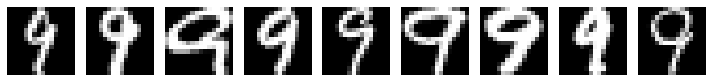

In [4]:
def get_image(nr,data):
    if 'label' in data.columns:
        data=np.array(data.drop('label',axis=1))
    else:
        data=data.values
    return np.reshape(data[nr,:],(16,16))

def display_multiple_img(images, rows = 3, cols=3):
    figure, ax = plt.subplots(nrows=rows,ncols=cols,figsize=(10,10))
    for ind,title in enumerate(images):
        ax.ravel()[ind].imshow(images[title],cmap='gray')
        ax.ravel()[ind].set_axis_off()
    plt.tight_layout()
    plt.show()

def display_digits(digit,data,rows,cols):
    total_images = rows*cols
    index=data.loc[data.label==digit].index[:total_images]
    images = {'Image'+str(i):get_image(i,data) for i in index}
    display_multiple_img(images, rows, cols)

    
for i in range(10):
    display_digits(i,df_train,rows=1,cols=9)

#### part 1
For each digit d in range(10) calculate the 'centre': $c_{d}$ as the mean of allcoordinates of vectors constructin $C_{d}$.
Once we have these centers, we can easily classify new images.

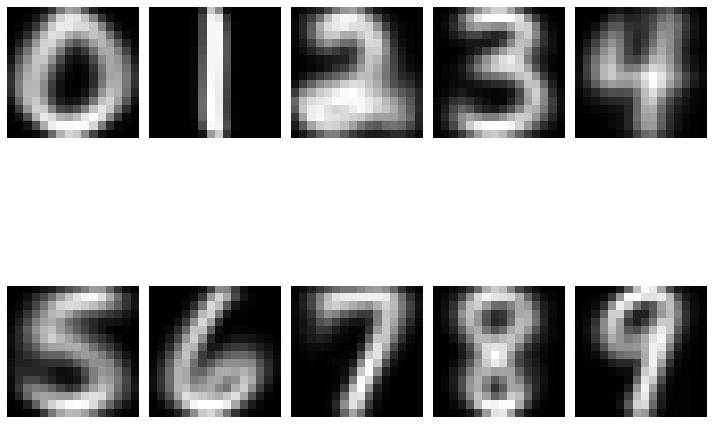

In [5]:
c_ds=df_train.groupby('label').mean()

images = {'Image'+str(i):get_image(i,c_ds) for i in range(10)}
display_multiple_img(images, 2,5)

Next, calculate the distances between the centers of the 10 clouds, $dist_{ij} = dist(c_{i}; c_{j} )$, for
$i,j = 0,1,...9$.

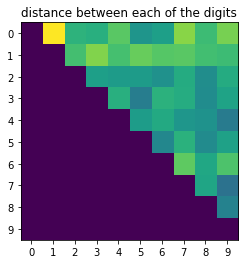

In [6]:
from itertools import product
dist_ij=np.zeros((10,10))
for i,j in product(range(10),range(10)):
    if j>=i:
        dist_ij[i,j]=np.linalg.norm(c_ds.iloc[i].values-c_ds.iloc[j].values)
imgplot = plt.imshow(dist_ij)
plt.title(label='distance between each of the digits')
plt.xticks(range(10))
plt.yticks(range(10))
plt.show()

#### Question
Given all these distances, try to say something about the expected accuracy of your
classifier. What pairs of digits seem to be most difficult to separate?
#### Answer
Looking at the graph i would suspect its hard to distinguish between 4 and 9, 7 and 9, 8 and 9, 3 and 5.  

#### Part 2: expirement with dimensionality reduction: PCA, LLE and t-SNE

In [7]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE, LocallyLinearEmbedding
from matplotlib import cm

In [8]:
#Dimension reduction
pca = PCA(n_components=2)
lle = LocallyLinearEmbedding(n_components=2)
tsne = TSNE(n_components=2)

methods={'pca':pca,'lle':lle,'tsne':tsne}
dfs=dict()
for key in methods:
    X=methods[key].fit_transform(X_train)
    df=pd.DataFrame(X)
    df['label']=Y_train
    dfs[key]=df

In [9]:
def scatter_plot(c_ds,title):
    fig, ax = plt.subplots()
    colors={0:'tab:red',1:'tab:blue',2:'tab:orange',3:'tab:green',4:'tab:purple',5:'tab:brown',6:'tab:pink',7:'tab:gray',8:'tab:olive',9:'tab:cyan'}
    for key in colors:
        x=c_ds.loc[c_ds.label==key].values[:,0]
        y=c_ds.loc[c_ds.label==key].values[:,1]
        ax.scatter(x,y, c=colors[key], label=key,
                   alpha=0.3, edgecolors='none')
    
    
    average=c_ds.groupby('label').mean()
    ax.scatter(average.values[:,0],average.values[:,1])
    for i in range(10):
        label = f"{c_ds.index[i]}"
        plt.annotate(label, # this is the text
             (average.values[i,0],average.values[i,1]), # this is the point to label
             textcoords="offset points", # how to position the text
             xytext=(0,10), # distance from text to points (x,y)
             ha='center') # horizontal alignment can be left, right or   
    ax.legend()
    plt.title(title)
    plt.show()

Distributions after dimension reduction:

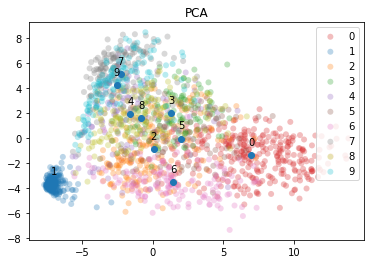

In [10]:
scatter_plot(dfs['pca'],'PCA')

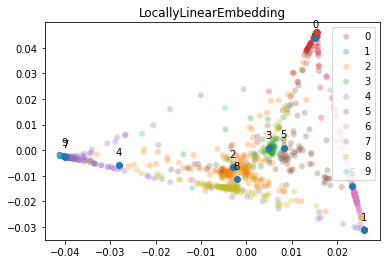

In [11]:
scatter_plot(dfs['lle'],'LocallyLinearEmbedding')

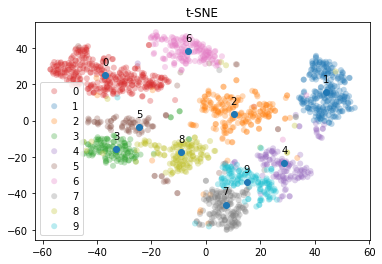

In [12]:
scatter_plot(dfs['tsne'],'t-SNE')

#### Part 3: implement the simplest distance-based classifier

In [13]:
class DistanceBasedClassifier:

    def __init__(self):
        self.c_ds=None
        
    def fit(self,X,Y):
        df_train = X.copy()
        df_train['label']=Y
        self.c_ds=df_train.groupby('label').mean()
    
    def predict(self,X):
        probability_matrix=pd.DataFrame()
        for i in range(10):
            df=X-self.c_ds.iloc[i]
            probability_matrix[i]=np.sqrt(np.multiply(df.abs(),df.abs()).sum(axis=1))
        predictions=np.argmin(probability_matrix.values,axis=1)
        #self.probabilities=1-(np.min(dbc.probability_matrix,axis=1)/np.sum(dbc.probability_matrix,axis=1))
        return predictions
    
    def score(self,X,Y):
        predictions=self.predict(X)
        acc=(np.sum(predictions==Y.values.T))/len(Y)
        return acc

In [14]:
dbc=DistanceBasedClassifier()
dbc.fit(X_train,Y_train)

In [15]:
prediction=dbc.predict(X_train)

Percentage correctly classified in trainset:

In [16]:
dbc.score(X_train,Y_train)

0.8635032220269478

In [17]:
X_test = pd.read_csv('./data/test_in.csv',header=None)
Y_test = pd.read_csv('./data/test_out.csv',header=None)

In [18]:
Y_pred_dbc=dbc.predict(X_test)

Percentage correctly classified in testset:

In [19]:
dbc.score(X_test,Y_test)

0.804

In [21]:
from sklearn.metrics import classification_report
print(classification_report(Y_test, Y_pred_dbc))

              precision    recall  f1-score   support

           0       0.90      0.79      0.85       224
           1       0.91      0.99      0.95       121
           2       0.85      0.68      0.76       101
           3       0.75      0.77      0.76        79
           4       0.67      0.80      0.73        86
           5       0.72      0.69      0.70        55
           6       0.75      0.87      0.80        90
           7       0.85      0.78      0.81        64
           8       0.74      0.79      0.76        92
           9       0.75      0.77      0.76        88

    accuracy                           0.80      1000
   macro avg       0.79      0.79      0.79      1000
weighted avg       0.81      0.80      0.80      1000



#### Part 4: the KNN approach

In [22]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train, Y_train.values.ravel())

KNeighborsClassifier()

In [23]:
Y_pred_knn=knn.predict(X_test)
knn.score(X_test,Y_test)

0.908

In [24]:

print(classification_report(Y_test, Y_pred_knn))


              precision    recall  f1-score   support

           0       0.90      0.98      0.94       224
           1       0.91      0.98      0.94       121
           2       0.93      0.83      0.88       101
           3       0.82      0.89      0.85        79
           4       0.94      0.92      0.93        86
           5       0.95      0.64      0.76        55
           6       0.94      0.94      0.94        90
           7       0.86      0.88      0.87        64
           8       0.95      0.86      0.90        92
           9       0.88      0.93      0.91        88

    accuracy                           0.91      1000
   macro avg       0.91      0.88      0.89      1000
weighted avg       0.91      0.91      0.91      1000



Confusion matrices

In [25]:
from sklearn.metrics import confusion_matrix,plot_confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

conf_matrix_knn=confusion_matrix(Y_test,Y_pred_knn)#confusion matrix knn
conf_matrix_dbc=confusion_matrix(Y_test,Y_pred_dbc)#confusion matrix distance based classifier

#def plot_conf_matrix(conf_matrix,title):
#    fig, ax = plt.subplots(figsize=(11,11))
#    ax.matshow(conf_matrix, aspect='auto')
#    ax.set(title=title, xticks=range(10), 
#           yticks=range(10))
#    for (i, j), val in np.ndenumerate(conf_matrix):
#        ax.annotate('{:0.2f}'.format(val), (j,i), ha='center', va='center',color='white')


In [26]:
#plot_conf_matrix(conf_matrix_knn,'Confusion Matrix for knn')

In [27]:
#plot_conf_matrix(conf_matrix_dbc,'Confusion Matrix for dbc')

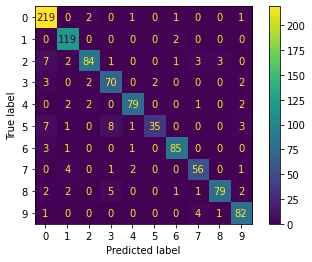

In [28]:
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix_knn)
disp = disp.plot()
plt.show()

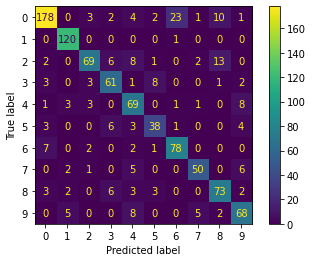

In [29]:
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix_dbc)
disp = disp.plot()
plt.show()

### Task 2: Implement a multi-class perceptron algorithm

In [30]:
X_train = pd.read_csv('./data/train_in.csv',header=None)
Y_train = pd.read_csv('./data/train_out.csv',header=None)
X_test = pd.read_csv('./data/test_in.csv',header=None)
Y_test = pd.read_csv('./data/test_out.csv',header=None)
df_train = X_train.copy()
df_train['label']=Y_train
T_train=X_train.copy()
T_train['bias']=1
T_test=X_test.copy()
T_test['bias']=1

Perceptron in pseudo code:
initialize weights at random. <br>
while there are misclassified examples: <br>
  for  misclassified examples:<br>
    if W_prediction > W_label: W_pred = W_pred-X<br>
    and W_label=W_label + X<br>


In [31]:
class MultiClassPerceptron:
    def __init__(self):
        self.weigths=None
    
    def fit(self,X,Y):
        W_x=X.shape[1]
        W_y=Y.shape[0]
        total=len(Y_train)
        W,counter,times_right,score=self.initialize((W_x,W_y))        
        
        while ((score<0.90) | (counter<30)):
            prediction=np.argmax(np.dot(X,W),axis=1)
            for i,(pred,label) in enumerate(zip(prediction,Y.values[:,0])):
                if pred != label:
                    W[:,pred]-=T_train.iloc[i]*(W[:,pred]>W[:,label])
                    W[:,label]+=T_train.iloc[i]*(W[:,pred]>W[:,label])
            times_right=sum(prediction.T==Y.values[:,0])
            score=times_right/total    
            counter+=1
        print(f'itaration {counter}, times right: {times_right},percentage: {score}')
        self.weigths=W
        
    def predict(self,X):
        W=self.weigths
        prediction=np.argmax(np.dot(X,W),axis=1)
        return prediction
    
    def initialize(self,shape):
        W=np.random.random(shape)
        (counter,times_right,score)=(0,0,0)
        return (W,counter,times_right,score)
    
    def score(self,X,Y):
        predictions=self.predict(X)
        acc=(np.sum(predictions==Y.values.T))/len(Y)
        return acc


In [32]:
mcp=MultiClassPerceptron()
mcp.fit(T_train,Y_train)

itaration 30, times right: 1576,percentage: 0.9232571763327475


In [33]:
Y_pred_mcp=mcp.predict(T_test)

In [34]:
print(classification_report(Y_test, Y_pred_mcp))

              precision    recall  f1-score   support

           0       0.87      0.95      0.91       224
           1       0.97      0.94      0.96       121
           2       0.80      0.75      0.78       101
           3       0.84      0.75      0.79        79
           4       0.74      0.77      0.75        86
           5       0.73      0.67      0.70        55
           6       0.95      0.81      0.87        90
           7       0.72      0.86      0.79        64
           8       0.74      0.79      0.76        92
           9       0.84      0.78      0.81        88

    accuracy                           0.83      1000
   macro avg       0.82      0.81      0.81      1000
weighted avg       0.84      0.83      0.83      1000



In [35]:
mcp.score(T_test,Y_test)

0.834

### Task 3

In [147]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def xor_net(x1, x2,weights):
    '''
    input 2-d
    hidden layer1 2 nodes
    hidden layer2 1 node, activation: sigmoid
    '''
    W1=np.reshape(weights[:4],(2,2))
    b1=weights[4:6]
    W2=np.reshape(weights[6:8],(2,1))
    b2=weights[-1]
    
    #input layer
    X0=np.array([x1,x2]).T
    # hidden layer1
    A1=np.dot(X0,W1)+b1
    Y1=sigmoid(A1)
    #hidden layer2
    A2=np.dot(Y1,W2)+b2
    Y=sigmoid(A2)
    return (Y,Y1,A1,A2)

In [37]:
weights=np.random.random(9)
x1=2
x2=3
xor_net(x1,x2,weights)

(array([0.9135386]), array([0.96890887, 0.98650859]))

In [38]:
def xor_net_2(x1, x2,weights):
    (w13,w14,w23,w24,bias3,bias4,w3y,w4y,biasy)=weights 
    Y=sigmoid(biasy+w3y*sigmoid(bias3+w13*x1+w23*x2)+w4y*sigmoid(bias4+w14*x1+w24*x2))
    return Y

weights = (biasy,bias3,bias4,w13,w14,w23,w24,w3y,w4y)

In [39]:
xor_net_2(x1, x2,weights)

0.913538595016349

In [40]:
#define data with corresponding targets
x = {'x1':[0,0,1,1],'x2':[0,1,0,1]}
xdf = pd.DataFrame(data=x)
y = {'target':[0,1,1,0]}
ydf = pd.DataFrame(data=y)
df=xdf.copy()
df['target']=y['target']

In [41]:
def mse(weights_initial,X_data,Y_data):
    sumerror=0
    for i in range(len(x['x1'])):
        errorsq = np.square(xor_net(X_data.iloc[i][0],X_data.iloc[i][1],weights_initial)
        -Y_data.iloc[i][0])
        sumerror+=errorsq
    mserror=sumerror/len(X_data['x1'])
    return mserror

def mse2(output,labels,W):
    mserror=np.square(output-labels).mean()
    return mserror,W

In [129]:
def grdmse(weights_initial,X_data,Y_data,delta):
    gradient=np.zeros(9)
    weights_delta=weights_initial.copy()
    for i in range(len(weights_initial)):
        weights_delta[i]+=delta
        gradient_i=(mse(weights_delta,X_data,Y_data)-mse(weights_initial,X_data,Y_data))/delta
        #op een of andere manier is weights_delta==weights_initial true hier?
        #hierdoor gradient_i=0
        weights_delta[i]-=delta
        gradient[i]+=gradient_i
    return gradient

def grdmse2(weights,X,Y1,Y,label):
    W1=np.reshape(weights[:4],(2,2))
    b1=weights[4:6]
    W2=np.reshape(weights[6:8],(2,1))
    b2=weights[-1]
    #dif=label-Y
    N=len(Y)
    
    dW2=Y*(1-Y)*(label-Y)*Y1
    db2=Y*(1-Y)*(label-Y)
    dW1=Y1*(1-Y1)*X*((Y*(1-Y)*(label-Y))*W2.T)
    db1=Y1*(1-Y1)*((Y*(1-Y)*(label-Y))*W2.T)

    d_weights=np.hstack([W1.ravel(),b1.ravel(),W2.ravel(),b2.ravel()])
    return d_weights

In [141]:
#initialisatie
x1=np.array([0,0,1,1])
x2=np.array([0,1,0,1])
X=np.array([x1,x2]).T
label=np.array([0,1,1,0]).reshape(4,1)

#weights random
weights=np.random.random(9)
#weights=np.ones(9)/3
#learning rate
etha=0.1

epochs=100
done=False



In [142]:
errors={}
misses={}
for i in range(epochs):
    #forward step
    Y,Y1,A1,A2=xor_net(x1, x2,weights)        
    #loss function
    error,W=mse2(Y,label,weights)
    #back prop
    d_weights=grdmse2(weights,X,Y1,Y,label)
    #update weights
    weights=weights-etha*d_weights
    mis_qualified=np.sum((Y>0.5)!=label)
    errors[i]=error
    misses[i]=mis_qualified
    if mis_qualified==0:
        break

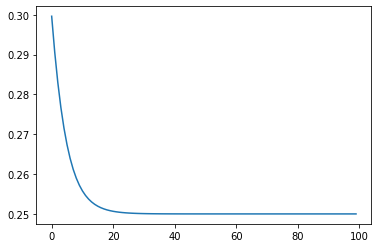

In [143]:
plt.plot(errors.keys(),errors.values())
plt.show()

In [133]:
misses[99]

2

In [148]:
x1=np.array([0,0,1,1])
x2=np.array([0,1,0,1])
X=np.array([x1,x2]).T
label=np.array([0,1,1,0]).reshape(4,1)

#weights random
weights=np.random.random(9)


array([0.29662964, 0.14853829, 0.10234615, 0.50679357, 0.20585721,
       0.33684267, 0.03042576, 0.22505866, 0.93904546])

In [155]:
#forward step
Y,Y1,A1,A2=xor_net(x1, x2,weights)        
#loss function
error,W=mse2(Y,label,weights)

#backprop

W1=np.reshape(weights[:4],(2,2))
b1=weights[4:6]
W2=np.reshape(weights[6:8],(2,1))
b2=weights[-1]

dW2=Y*(1-Y)*(label-Y)*Y1
db2=Y*(1-Y)*(label-Y)
dW1=Y1*(1-Y1)*X*((Y*(1-Y)*(label-Y))*W2.T)
db1=Y1*(1-Y1)*((Y*(1-Y)*(label-Y))*W2.T)

d_weights=np.hstack([W1.ravel(),b1.ravel(),W2.ravel(),b2.ravel()])
d_weights

array([0.29662964, 0.14853829, 0.10234615, 0.50679357, 0.20585721,
       0.33684267, 0.03042576, 0.22505866, 0.93904546])